In [1]:
from PIL import Image
import matplotlib.pyplot as plt

from performance import compute_miner_performance
from helpers import formatted_ts_from_epoch, epoch_from_formatted_ts
from data import get_wanbd_runs

### Querying mainnet wandb

In [2]:
project = "bitmind-subnet"  # mainnet wandb project name
entity = "bitmindai"
validator_run_name = None #'validator-122-1.2.2'
start_dt = '2024-10-22T13:09:49'
# start_dt = formatted_ts_from_epoch(1729494162)
end_dt = None

miner_uid = 0
print(f'Querying data for uid {miner_uid} starting at {start_dt}')

Querying data for uid 0 starting at 2024-10-22T13:09:49


In [3]:
runs = get_wanbd_runs(entity, project, start_dt, end_dt, validator_run_name)

Querying w&b with filters: {'created_at': {'$gte': '2024-10-22T13:09:49'}}


In [4]:
metrics_df, fake_image_preds, miner_preds = compute_miner_performance(
    runs,
    miner_uid=miner_uid,  # example uid
    start_ts=epoch_from_formatted_ts(start_dt),
    end_ts=epoch_from_formatted_ts(end_dt),
    validator_run_name=validator_run_name,
    download_fake_images=True)

display(metrics_df)

,uid,accuracy,precision,recall,f1,auc,sample_size
0,0,0.852941,1.0,0.782609,0.878049,0.960474,34


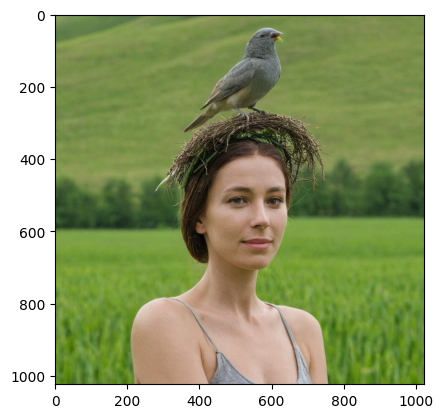

predictions: {0: 0.9993975162506104}


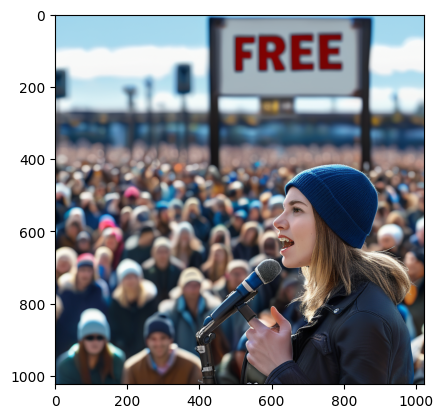

predictions: {0: 0.9316092133522034}


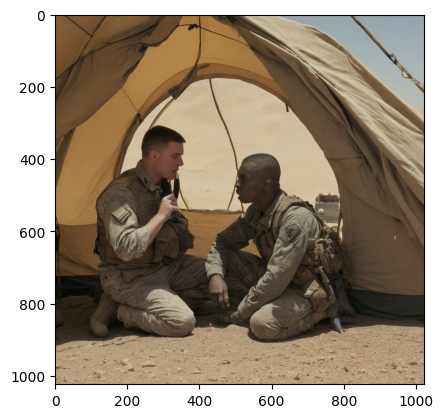

predictions: {0: 0.04510166496038437}


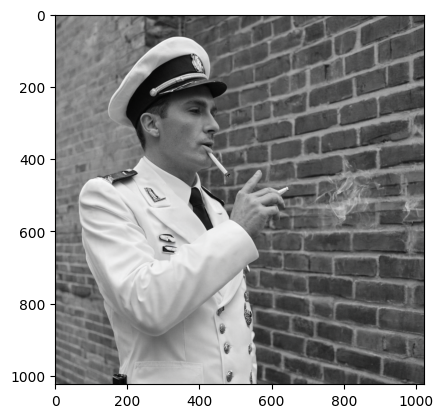

predictions: {0: 0.8992632031440735}


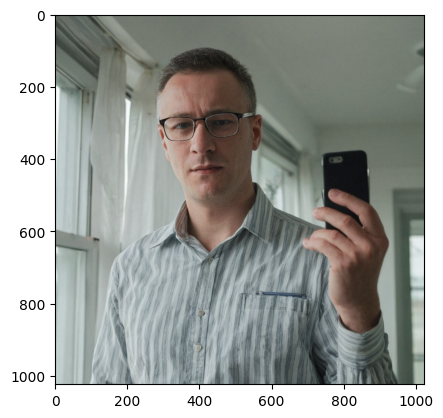

predictions: {0: 0.9990921020507812}


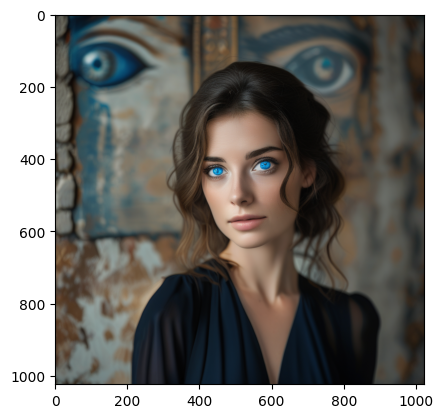

predictions: {0: 0.9997285008430481}


In [18]:
show_N = 5
for i, path in enumerate(fake_image_preds):
    if i > show_N:
        break
    img = Image.open(path)
    plt.imshow(img)
    plt.show()
    print("predictions:", fake_image_preds[path])

### Querying testnet wandb

In [15]:
project = "bitmind"  # mainnet wandb project name
entity = "bitmindai"
validator_run_name = 'validator-39-1.2.2'
start_dt = '2024-10-22T16:09:49'
# start_dt = formatted_ts_from_epoch(1729494162)
end_dt = None

miner_uid = None
print(f'Querying data for uid {miner_uid} starting at {start_dt}')

Querying data for uid None starting at 2024-10-22T16:09:49


In [16]:
runs = get_wanbd_runs(entity, project, start_dt, end_dt, validator_run_name)

Querying w&b with filters: {'display_name': 'validator-39-1.2.2', 'created_at': {'$gte': '2024-10-22T16:09:49'}}


In [17]:
metrics_df, fake_image_preds, miner_preds = compute_miner_performance(
    runs,
    miner_uid=miner_uid,  # example uid
    start_ts=epoch_from_formatted_ts(start_dt),
    end_ts=epoch_from_formatted_ts(end_dt),
    validator_run_name=validator_run_name,
    download_fake_images=True)

display(metrics_df)

,uid,accuracy,precision,recall,f1,auc,sample_size
0,198,0.75,0.75,1.000000,0.857143,0.666667,4
1,218,0.50,1.00,0.333333,0.500000,1.000000,4
2,225,0.75,0.75,1.000000,0.857143,0.666667,4
3,217,0.50,1.00,0.333333,0.500000,1.000000,4
4,216,0.75,0.75,1.000000,0.857143,0.666667,4
5,196,0.75,0.75,1.000000,0.857143,0.666667,4
